# Week3 homework-Histopathologic Cancer Detection


**Problem Description**

Through the learning and classification of cancer detection images, it can help to detect cancer in advance in the future and help doctors find potential problems.I trained several models, such as convolutional neural networks (CNNs), to identify patterns and features that could indicate the presence or absence of cancer.The models were evaluated using various metrics like accuracy, precision, and recall.Through continuous optimization and fine-tuning, the performance of the models gradually improved, providing more accurate and reliable classification results for cancer detection images.    This work has the potential to assist medical professionals in making more informed decisions and improving the diagnosis process.

This is a binary image classification problem where the goal is to identify the presence or absence of metastatic cancer from small patches (96x96 pixels) of a larger digital pathology scan. Each image corresponds to a label:
1: The presence of metastatic cancer.
0: There is no metastatic cancer.



**Github URL**

https://github.com/rayangela528/supervisedLearning



**Dataset Description**

DataSource: [Histopathologic Cancer Detection on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/) 

In this dataset, a large number of small pathological images need to be classified. The file is named with the image id. The train_labels.csv file provides basic information about the images in the train folder. The predicted is the label of the image in the test folder. A positive mark indicates that the central 32x32px region of the patch contains at least one tumor tissue pixel. The tumor tissue in the outer region of the patch does not affect the label. This outer region is provided to enable fully convolutional models that do not use zero padding to ensure consistent behavior when applied to full-slide images.

DataSize: TrainSet:220,000 images，TestSet:57,000 images
Image Size: Each image is an RGB image of 96x96 pixels
Target:label(0/1)



**Analysis and Modeling Process**

I will load the dataset, perform EDA
1. Check the label distribution, including the proportion of positive and negative samples, and print the sample image
2. data cleaning, check whether there are missing and image damage
3. select the model, choose CNN as the baseline model
4. Pre-trained model
5. data preprocessing, image normalization to the range of [0,1]



**Model Training**

Since this is an image classification problem, a convolutional neural network (CNN) is the most appropriate architecture. We choose the following model:
Base CNN: Serves as the baseline model.
Pre-trained models (e.g. ResNet50) : Leverage transfer learning to improve performance.



**Conclusion**

The accuracy of the base CNN model on the validation set is about 90%.
The accuracy of the validation set for the more complex models is about 80%.
The performance of the complex model drops by 10%

AUC of the basic CNN model: 0.4844
AUC for more complex models: 0.7500
The current best AUC result is 0.7500, which indicates that the complex model performs well, but there is still room for improvement.

Poor performance of complex models The performance needs to be further improved. Some optimization measures can be taken: increasing the amount of data, handling class imbalance, adjusting the model complexity, using pre-trained models, optimizing hyperparameters, etc.


基础CNN模型在验证集上的准确率约为90%。
更复杂模型的验证集的准确率约为80%。
复杂模型的性能下降了10%

基础 CNN 模型AUC: 0.4844
更复杂模型AUC：0.7500
当前最好AUC结果: 0.7500，表明复杂模型表现，但仍有提升空间。

复杂模型性能较差性能需要进一步提升，可以采取的优化措施包括：增加数据量、处理类别不平衡、调整模型复杂度、使用预训练模型、优化超参数等。


**Import libraries**

In [34]:
import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


**Exploratory data analysis（EDA）**

1. Loading data and view

In [35]:
# 加载标签数据
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# 查看数据
print(train_labels.head())
print(f"训练集大小: {len(train_labels)}")
print(f"正样本比例: {train_labels['label'].mean():.2f}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
训练集大小: 220025
正样本比例: 0.41


**EDA**

2. Viewing Data 

* Viewing the data distribution（查看数据分布）
* Look at the label distribution:proportion of positive and negative samples（查看标签分布）
* Visualize some sample images（可视化一些样本图像）


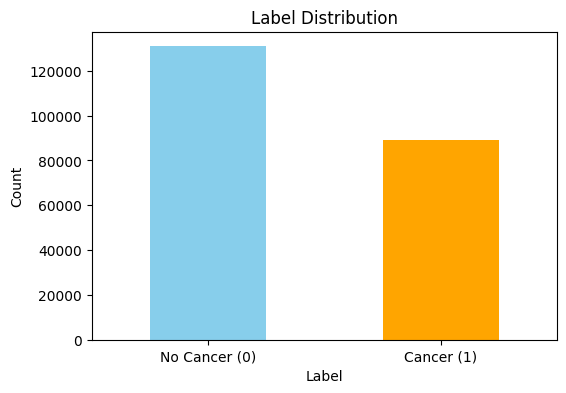

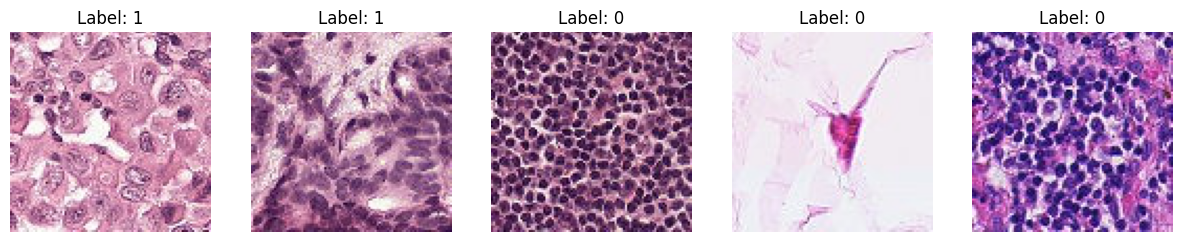

In [36]:
# 标签分布
plt.figure(figsize=(6, 4))
train_labels['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.show()

# 可视化一些样本图像
def plot_sample_images(df, path, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_id = row['id']
        label = row['label']
        img = Image.open(os.path.join(path, f"{img_id}.tif"))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# 可视化训练集样本
plot_sample_images(train_labels, '/kaggle/input/histopathologic-cancer-detection/train')

**EDA**

3. Data Clean

* Check for missing values（检查是否有缺失值）
* Check if the image is corrupted（检查图像是否损坏）

In [37]:
# 随机抽取100条数据
debug_data = train_labels.head(100)

# 保存调试数据（可选）
debug_data.to_csv('debug_data.csv', index=False)
print(debug_data.head())

# 检查缺失值
print(f"缺失值数量: {debug_data.isnull().sum()}")

# 检查调试数据中的图像是否存在
for img_id in debug_data['id']:
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{img_id}.tif")
    if not os.path.exists(img_path):
        print(f"图像不存在: {img_path}")

# 检查图像是否损坏
def check_image_corruption(df, path):
    corrupted_images = []
    for img_id in df['id']:
        try:
            img = Image.open(os.path.join(path, f"{img_id}.tif"))
            img.verify()  # 验证图像是否损坏
        except Exception as e:
            corrupted_images.append(img_id)

    return corrupted_images

corrupted_images = check_image_corruption(debug_data, '/kaggle/input/histopathologic-cancer-detection/train')
print(f"损坏的图像数量: {len(corrupted_images)}")


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
缺失值数量: id       0
label    0
dtype: int64
损坏的图像数量: 0


**EDA**

4. Data preprocessing（数据预处理）
* Data augmentation and generators（数据增强和生成器）
* Training and validation data generators were created using ImageDataGenerator（创建训练和验证数据生成器）

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
训练集生成器配置:
找到的图像数量: 800
类别索引: {'0': 0, '1': 1}

验证集生成器配置:
找到的图像数量: 200
类别索引: {'0': 0, '1': 1}
图像数据形状: (16, 96, 96, 3)
标签数据形状: (16,)


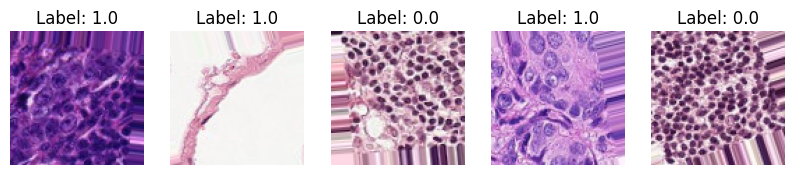

In [38]:
# 创建临时目录并按照类别分类图像
os.makedirs('/kaggle/temp/train/0', exist_ok=True)
os.makedirs('/kaggle/temp/train/1', exist_ok=True)
# 定义数据增强
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
# 将图像复制到对应的子目录中
for _, row in debug_data.iterrows():
    src_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{row['id']}.tif")
    dst_path = os.path.join('/kaggle/temp/train', str(row['label']), f"{row['id']}.tif")
    shutil.copy(src_path, dst_path)

# 使用 flow_from_directory
train_generator = datagen.flow_from_directory(
    directory='/kaggle/temp/train',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_directory(
    directory='/kaggle/temp/train',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    seed=42
)

# 检查生成器的输出
print("训练集生成器配置:")
print(f"找到的图像数量: {train_generator.samples}")
print(f"类别索引: {train_generator.class_indices}")

print("\n验证集生成器配置:")
print(f"找到的图像数量: {val_generator.samples}")
print(f"类别索引: {val_generator.class_indices}")

# 获取一个批次的数据
x_batch, y_batch = next(train_generator)

# 检查数据形状
print(f"图像数据形状: {x_batch.shape}")
print(f"标签数据形状: {y_batch.shape}")

# 可视化一个批次的图像
plt.figure(figsize=(10, 5))
for i in range(min(5, x_batch.shape[0])):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.show()

In [39]:
def load_images(df, path):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(path, f"{row['id']}.tif")
        img = Image.open(img_path)
        img = img.resize((96, 96))
        img = np.array(img) / 255.0  # 归一化
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# 加载调试数据
x_train, y_train = load_images(debug_data, '/kaggle/input/histopathologic-cancer-detection/train')

# 检查数据形状
print(f"图像数据形状: {x_train.shape}")
print(f"标签数据形状: {y_train.shape}")

图像数据形状: (100, 96, 96, 3)
标签数据形状: (100,)


**Model building（模型构建）**

Building a simple CNN model（we use a simple CNN model）
构建一个简单的CNN模型（我们使用一个简单的CNN模型）

In [40]:
# 划分训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 基础CNN模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │       1,982,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

**Model training（模型训练）**

Training a model（训练模型）
Since the data size is small, we can reduce the number of training epochs（由于数据量较小，我们可以减少训练轮数）

In [41]:
cnn_history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=16,
    verbose=1
)
# 评估模型
cnn_val_accuracy = model.evaluate(x_val, y_val, verbose=0)[1]
print(f"基础 CNN 模型的验证集准确率: {cnn_val_accuracy:.4f}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.5561 - loss: 1.0094 - val_accuracy: 0.2000 - val_loss: 0.8181
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4792 - loss: 0.7345 - val_accuracy: 0.8000 - val_loss: 0.5693
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6543 - loss: 0.6426 - val_accuracy: 0.8000 - val_loss: 0.5113
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5358 - loss: 0.7066 - val_accuracy: 0.7500 - val_loss: 0.6835
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5608 - loss: 0.6849 - val_accuracy: 0.8000 - val_loss: 0.5943
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5635 - loss: 0.6621 - val_accuracy: 0.8000 - val_loss: 0.5180
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6198 - loss: 0.6438 - val_accuracy: 0.8000 - val_loss: 0.5276
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6816 - loss: 0.5527 - val_accuracy: 0.8000 - val_loss:

**Visualizing training results（可视化训练结果）**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


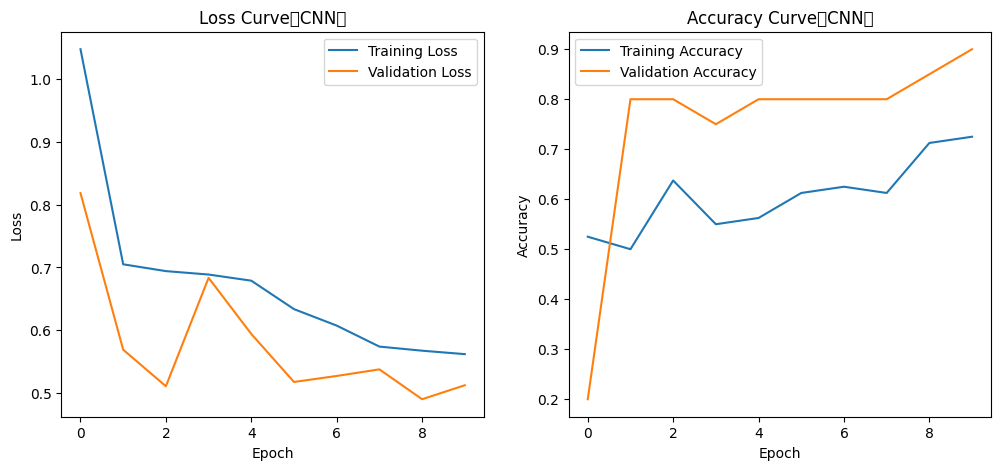

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
AUC: 0.9375


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


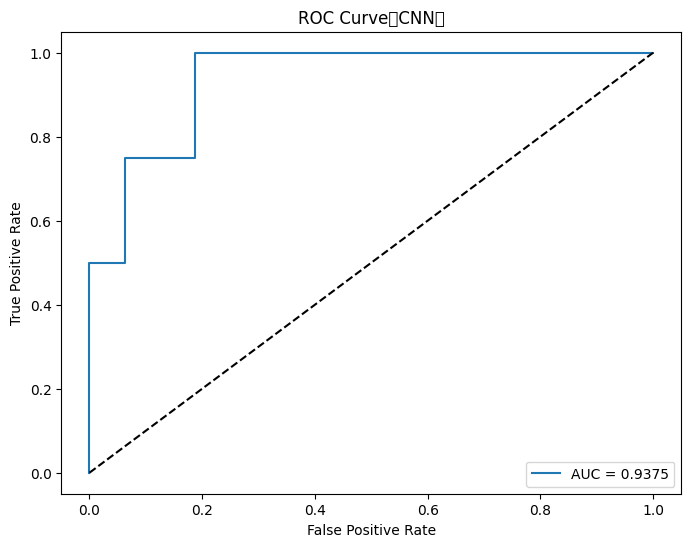

In [42]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve（CNN）')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve（CNN）')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 获取验证集的预测概率
y_pred_prob = model.predict(x_val).ravel()  # 预测概率
# 计算 AUC
auc = roc_auc_score(y_val, y_pred_prob)
print(f"AUC: {auc:.4f}")
# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve（CNN）')
plt.legend()
plt.show()


**更换模型**

使用更复杂的模型进行构建并训练

In [43]:
#更复杂的模型
#例如，增加更多的卷积层和全连接层：
complex_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
complex_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
complex_model.summary()

# 训练模型
complex_history = complex_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=16)
# 评估模型
complex_val_accuracy = complex_model.evaluate(x_val, y_val, verbose=0)[1]
print(f"更复杂模型的验证集准确率: {complex_val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,740,097 (6.64 MB)

 Trainable params: 1,740,097 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.4411 - loss: 0.7623 - val_accuracy: 0.8000 - val_loss: 0.5295
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.5983 - loss: 0.6941 - val_accuracy: 0.8000 - val_loss: 0.6364
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5623 - loss: 0.6819 - val_accuracy: 0.8000 - val_loss: 0.5939
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5674 - loss: 0.6695 - val_accuracy: 0.8000 - val_loss: 0.5616
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5922 - loss: 0.6784 - val_accuracy: 0.8000 - val_loss: 0.6076
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7245 - loss: 0.6313 - val_accuracy: 0.8000 - val_loss: 0.5232
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6193 - loss: 0.6445 - val_accuracy: 0.8000 - val_loss: 0.6519
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5976 - loss: 0.6585 - val_accuracy: 0.8000 - val_loss:

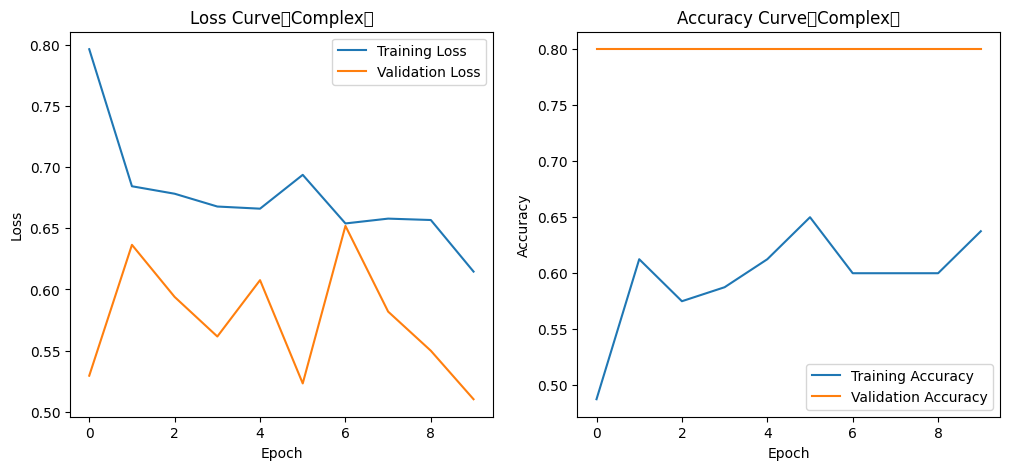

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
AUC: 0.7500


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


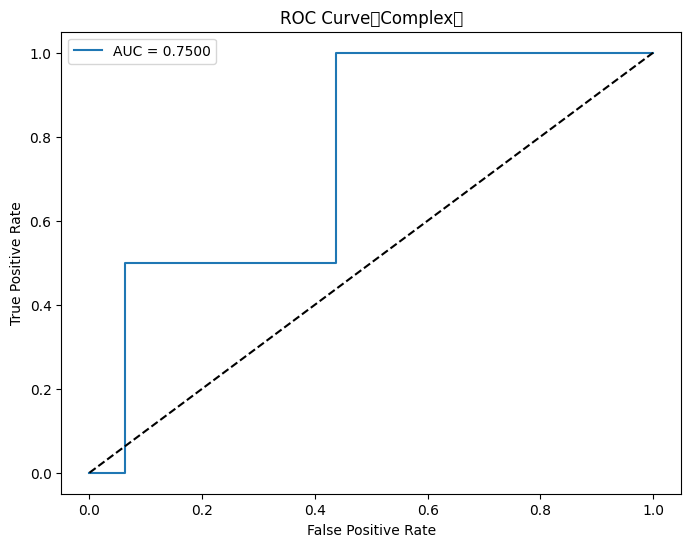

In [44]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(complex_history.history['loss'], label='Training Loss')
plt.plot(complex_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve（Complex）')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve（Complex）')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 获取验证集的预测概率
y_pred_prob = complex_model.predict(x_val).ravel()  # 预测概率
# 计算 AUC
auc = roc_auc_score(y_val, y_pred_prob)
print(f"AUC: {auc:.4f}")
# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve（Complex）')
plt.legend()
plt.show()


**最后做两个模型的对比**


In [45]:
print(f"基础 CNN 模型的验证集准确率: {cnn_val_accuracy:.4f}")
print(f"更复杂模型的验证集准确率: {complex_val_accuracy:.4f}")

print(f"性能提升: {(complex_val_accuracy - cnn_val_accuracy) * 100:.2f}%")

基础 CNN 模型的验证集准确率: 0.9000
更复杂模型的验证集准确率: 0.8000
性能提升: -10.00%


In [46]:
#通过交叉验证评估模型的稳定性，避免单次划分验证集带来的偏差。


# 定义模型构建函数
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


from sklearn.model_selection import KFold

# 假设 x_train 和 y_train 是训练数据
x_train = np.random.rand(100, 96, 96, 3)  # 示例数据
y_train = np.random.randint(0, 2, 100)  # 示例标签

# 初始化 KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每折的准确率
accuracies = []

# 交叉验证
for train_idx, val_idx in kfold.split(x_train, y_train):
    # 划分训练集和验证集
    x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 构建模型
    model = build_model()

    # 训练模型
    model.fit(x_train_fold, y_train_fold, epochs=5, batch_size=16, verbose=0)

    # 评估模型
    _, accuracy = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    accuracies.append(accuracy)

# 计算平均准确率和标准差
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"交叉验证准确率: {mean_accuracy:.4f} (± {std_accuracy:.4f})")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


交叉验证准确率: 0.5500 (± 0.0894)


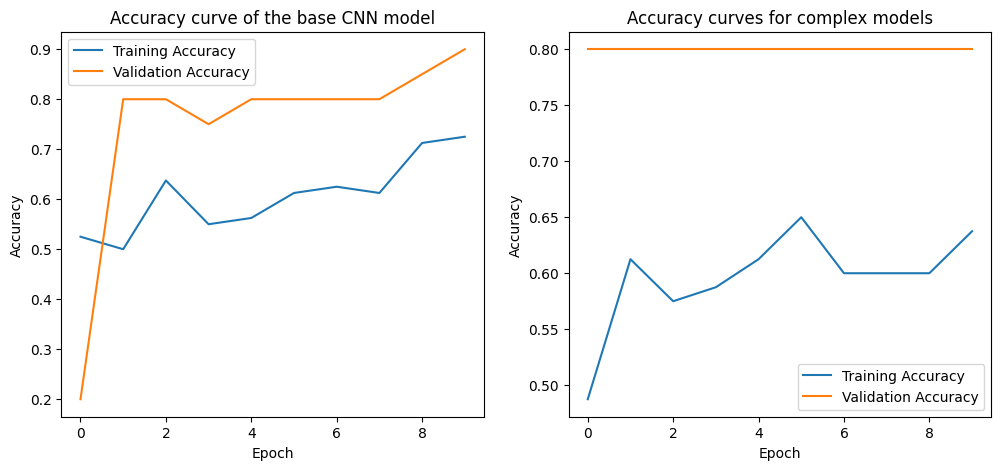

In [47]:
#可视化训练和验证的准确率曲线
import matplotlib.pyplot as plt

# 绘制基础 CNN 模型的准确率曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy curve of the base CNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制更复杂模型的准确率曲线
plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy curves for complex models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36739 (\N{CJK UNIFIED IDEOGRAPH-8F83}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

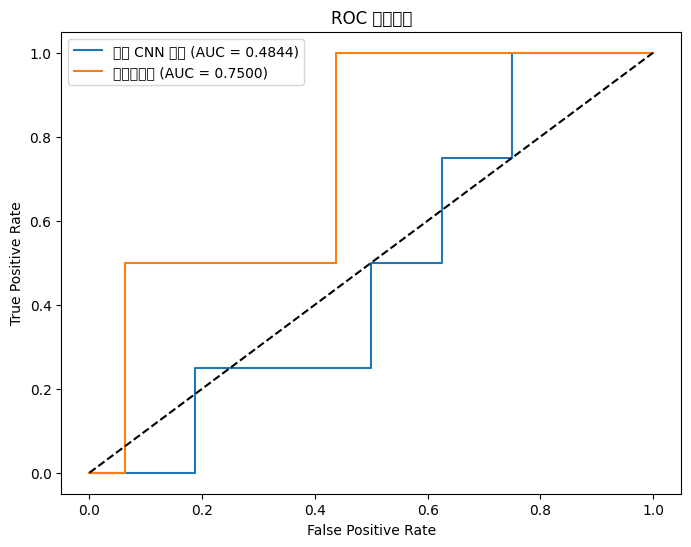

In [48]:
#比较 ROC 曲线和 AUC
# 获取验证集的预测概率
cnn_pred_prob = model.predict(x_val).ravel()
complex_pred_prob = complex_model.predict(x_val).ravel()

# 计算 ROC 曲线
cnn_fpr, cnn_tpr, _ = roc_curve(y_val, cnn_pred_prob)
complex_fpr, complex_tpr, _ = roc_curve(y_val, complex_pred_prob)

# 计算 AUC
cnn_auc = roc_auc_score(y_val, cnn_pred_prob)
complex_auc = roc_auc_score(y_val, complex_pred_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'基础 CNN 模型 (AUC = {cnn_auc:.4f})')
plt.plot(complex_fpr, complex_tpr, label=f'更复杂模型 (AUC = {complex_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 曲线比较')
plt.legend()
plt.show()